In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as ET
from lxml import etree
import sys

In [3]:
run -im djd.main -- --dbname=dj_lisa -r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting write@localhost:3306
Connected to database 'dj_lisa' as 'write@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSH


In [4]:
sys.path.insert(0,'../')
print(sys.path)
print(os.getcwd())

['../', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/gpfs01/berens/user/lschmors/.local/lib/python3.6/site-packages', '/gpfs01/berens/user/lschmors/Code/dLGN_project/expio', '/gpfs01/berens/user/lschmors/Code/dLGN_project/djd', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/gpfs01/berens/user/lschmors/.local/lib/python3.6/site-packages/IPython/extensions', '/gpfs01/berens/user/lschmors/.ipython']
/gpfs01/berens/user/lschmors/Code/dLGN_project/hollymov_code/notebooks


In [5]:
import hollymov_utils

Define Key:

In [6]:
key_s04e09 = {'m': 'Ntsr1Cre_2019_0003', 's': 4, 'e': 9}

## Get time ranges

Time ranges of the stimulus:

In [7]:
stim_tranges, stim_IDs = (trial&key_s04e09).get_tranges()
stim_tranges

array([[  61.6205,   86.6676],
       [  86.671 ,  357.1925],
       [ 357.202 ,  382.2502],
       [ 382.251 ,  652.7728],
       [ 652.782 ,  677.8302],
       [ 737.948 ,  762.996 ],
       [ 762.9985, 1033.5209],
       [1033.496 , 1058.5443],
       [1058.545 , 1329.0675],
       [1329.076 , 1354.1243]])

Time ranges of the opto events (start and stop of each opto pulse):

In [8]:
evtimesopto_s04e09 = (Event.Times()&{'m': 'Ntsr1Cre_2019_0003', 's': 4, 'e': 9, 'u':'14','ev_chan':'opto1'}).fetch('ev_tranges')

Time ranges of every second (also those that have no opto condition):

In [9]:
tranges_all_s04e09 = hollymov_utils.get_all_tranges(evtimesopto_s04e09)
tranges_all_s04e09

array([[   3.469,    4.469],
       [   4.471,    5.471],
       [   5.473,    6.473],
       ...,
       [1411.232, 1412.232],
       [1412.234, 1413.234],
       [1413.236, 1414.236]])

Time ranges that are within the time of the stimulus (not spont opto)

In [10]:
evtranges_stim = tranges_all_s04e09[util.intersect_tranges(stim_tranges, tranges_all_s04e09)]

Time ranges that are within the stimulus but depending on opto/no-opto condition:

In [11]:
# get the opto, no opto mask
_, _, opto = (spk & {'m': 'Ntsr1Cre_2019_0003', 's': '4', 'e': '9'}).get_tranges(tranges=tranges_all_s04e09)
no_opto = ~opto

# get array with time ranges depending on conditon
tranges_opto_s04e09 = tranges_all_s04e09[opto]
tranges_noopto_s04e09 = tranges_all_s04e09[no_opto]

Time ranges of the 4 conditons:

In [12]:
# (1) condition: opto on switch 
tranges_opto_on_s04e09_all = hollymov_utils.get_tranges_cond_swit(tranges_opto_s04e09)
# (2) condition: opto on continuity
tranges_opto_cont_s04e09_all = hollymov_utils.get_tranges_cond_cont(tranges_opto_s04e09)
# (3) condition: opto off switch 
tranges_opto_off_s04e09_all = hollymov_utils.get_tranges_cond_swit(tranges_noopto_s04e09)
# (4) condition: no opto continuity
tranges_noopto_cont_s04e09_all = hollymov_utils.get_tranges_cond_cont(tranges_noopto_s04e09)

# select only those that are in stim and not spontOpto
tranges_opto_on_s04e09 = tranges_opto_on_s04e09_all[util.intersect_tranges(stim_tranges, tranges_opto_on_s04e09_all)]
tranges_opto_cont_s04e09 = tranges_opto_cont_s04e09_all[util.intersect_tranges(stim_tranges, tranges_opto_cont_s04e09_all)]
tranges_opto_off_s04e09 = tranges_opto_off_s04e09_all[util.intersect_tranges(stim_tranges, tranges_opto_off_s04e09_all)]
tranges_noopto_cont_s04e09 = tranges_noopto_cont_s04e09_all[util.intersect_tranges(stim_tranges, tranges_noopto_cont_s04e09_all)]

Time ranges of the spontaneous opto condition:

In [13]:
xptranges_spont = hollymov_utils.get_xptranges_spont(key_s04e09)
xptranges_spont 

array([[-8.33300000e-03,  6.01077670e+01],
       [ 6.76298267e+02,  7.36414267e+02],
       [ 1.35260477e+03,  1.41272077e+03]])

In [14]:
# get all event time ranges within spontOpto       
evtranges_spont = tranges_all_s04e09[util.intersect_tranges(xptranges_spont, tranges_all_s04e09)]

# Plotting

## Spike rasters

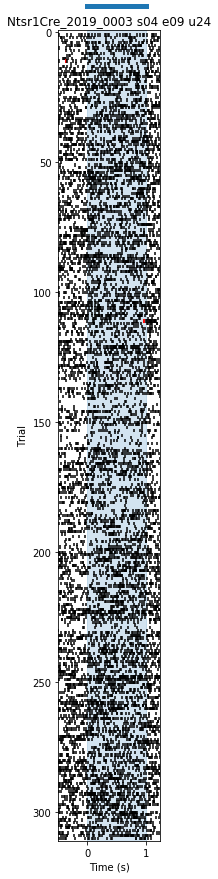

In [15]:
(spk & {'m': 'Ntsr1Cre_2019_0003', 's':4, 'e':9, 'u':24}).traster(offsets=[-0.5, 0.25], stimis=False, tranges=tranges_opto_on_s04e09, title=True, optocolor='k', eventbar=True, bursts=True, eventfill=True)

## PSTH of spontaneous opto

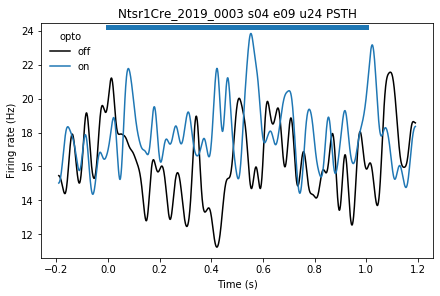

In [16]:
(spk & {'m': 'Ntsr1Cre_2019_0003', 's':4, 'e':9, 'u':24}).psth(offsets=[-0.2, 0.2], trangesin=evtranges_spont, title=True, eventbar=True)

## Opto effect during visual stimulation

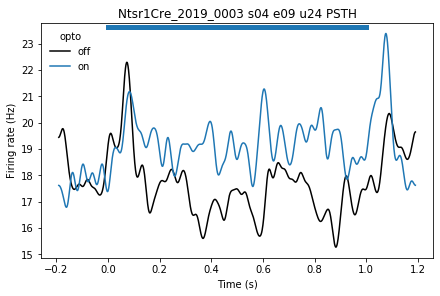

In [17]:
(spk & {'m': 'Ntsr1Cre_2019_0003', 's':4, 'e':9,'u':24}).psth(offsets=[-0.2, 0.2], trangesin=evtranges_stim, title=True, eventbar=True)

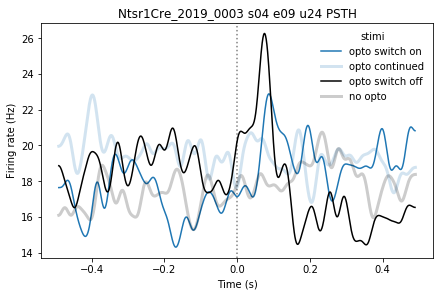

In [18]:
m = 'Ntsr1Cre_2019_0003'
s = 4
e = 9
u = 24
offset = [-0.5, -0.5]

hollymov_utils.psth_cond_trace(m, s, e, u, offset)

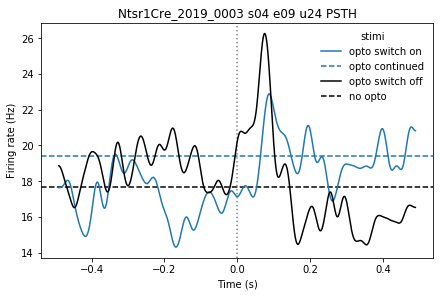

In [19]:
hollymov_utils.psth_cond_base(m, s, e, u, offset)

## Firing rate as bar graph

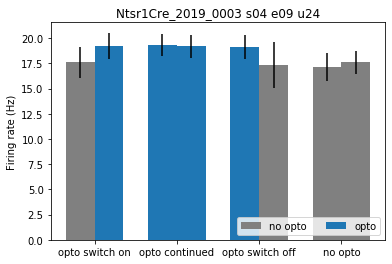

In [20]:
#units = [14, 24]
units = [24]

for ukey in units:
    u = ukey
    hollymov_utils.bar_cond(m, s, e, u)
    #plt.savefig(('plots/Ntsr1Cre_2019_0003_s04_e05_u'+str(ukey)+'.png'), dpi = 300)